# Production Planning

In [25]:
from io import StringIO

import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Data from Problem 12.3 from the book Model Building in Mathematical Programming (H. Paul Williams)
# Two entries in the top row changed

file = StringIO("""
10 6 8 4 11 9 3
0.5 0.7 – – 0.3 0.2 0.5
0.1 0.2 – 0.3 – 0.6 –
0.2 – 0.8 – – – 0.6
0.05 0.03 – 0.07 0.1 – 0.08
 – – 0.01 – 0.05 – 0.05
 """)

# Column names for the big Data Frame
columns = ["Profit", "Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]

production = pd.read_csv(file, header=None, sep="\s+", na_values=["–"]).fillna(0).T
production.columns = columns
production.reindex(list(range(production.shape[0])))
production.index.name = "Product"

# keep profit coefficients in a separate series
profit = production["Profit"]
production.drop("Profit", axis=1, inplace=True)

# A little modification to the profit data to make the products more "competitive" against each other
profit[0] = 7
profit[4] = 8

# Numbers of machines of different types
nb_machines = pd.Series(
    [4, 2, 3, 1, 1], index=["Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]
)
# total hours per month = 24 working days times 8 hours
hours = 24 * 8

display("production", production)
display("profit", profit)

'production'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.5,0.1,0.2,0.05,0.00
1,0.7,0.2,0.0,0.03,0.00
2,0.0,0.0,0.8,0.00,0.01
3,0.0,0.3,0.0,0.07,0.00
4,0.3,0.0,0.0,0.10,0.05
5,0.2,0.6,0.0,0.00,0.00
6,0.5,0.0,0.6,0.08,0.05


'profit'

Product
0    7.0
1    6.0
2    8.0
3    4.0
4    8.0
5    9.0
6    3.0
Name: Profit, dtype: float64

## Nominal Model


In [27]:
# creating and solving a nominal production model

def production_model(nb_machines, production, profit, hours):
    
    m = pyo.ConcreteModel("Production planning")

    m.products = pyo.Set(initialize=profit.index)
    m.resources = pyo.Set(initialize=production.columns)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.products, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def total_profit(m):
        return profit @ m.x

    @m.Constraint(m.resources)
    def machine_availability(m, r):
        return production[r] @ m.x <= hours * nb_machines[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m


m = production_model(nb_machines, production, profit, hours)
m.display()

nominal_plan = pd.Series({i: m.x[i]() for i in m.products}, name="Robust")


Model Production planning

  Variables:
    x : Size=7, Index=products
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          0 :     0 :       0.0 :  None : False : False : NonNegativeReals
          1 :     0 : 117.79141 :  None : False : False : NonNegativeReals
          2 :     0 :     720.0 :  None : False : False : NonNegativeReals
          3 :     0 :       0.0 :  None : False : False : NonNegativeReals
          4 :     0 : 1884.6626 :  None : False : False : NonNegativeReals
          5 :     0 :  600.7362 :  None : False : False : NonNegativeReals
          6 :     0 :       0.0 :  None : False : False : NonNegativeReals

  Objectives:
    total_profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 26950.67506

  Constraints:
    machine_availability : Size=5
        Key        : Lower : Body               : Upper
            Boring :  None : 192.00000230000003 : 192.0
          Grinding :  None :         768.0000

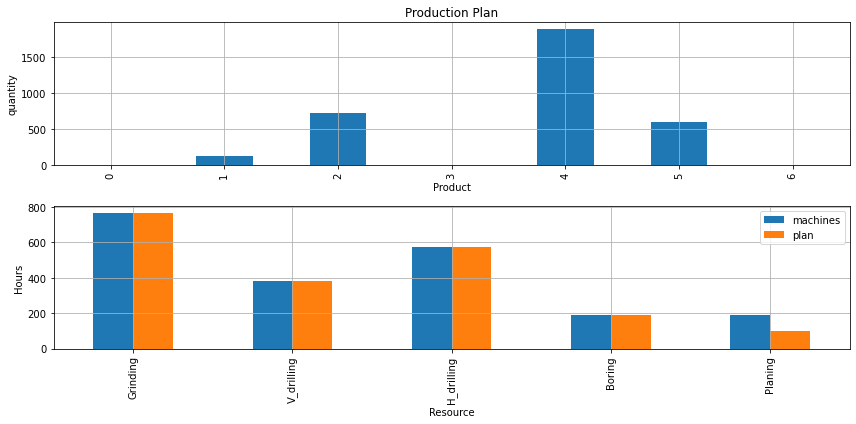

In [28]:
def display_plan(m, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    x = pd.Series({p: m.x[p]() for p in m.products}, name="Nominal")
    x.plot(ax=ax[0], kind="bar", xlabel="Product", ylabel="quantity", title="Production Plan", grid=True)

    resources = pd.concat([hours*nb_machines, production.T @ x], axis=1)
    resources.columns = ["machines", "plan"]
    resources.plot(ax=ax[1], kind="bar", xlabel="Resource", ylabel="Hours", grid=True)
    
    fig.tight_layout()
    
    return ax

display_plan(m);

## Robust Optimization


In [38]:
# We shall now solve the robust problem with each (product, machine) time deviating
# by at most max_perturbation * 100%,
# and per machine the  at most unc_budget products in total deviate by their max

max_perturbation = 0.05
unc_budget = 1

production_perturbation = production.applymap(lambda x: x * max_perturbation)
display("production perturbation", production_perturbation)

m = pyo.ConcreteModel("Production planning")

m.products = pyo.Set(initialize=profit.index)
m.resources = pyo.Set(initialize=production.columns)

# Old variables
m.p = pyo.Var(m.products, domain=pyo.NonNegativeReals)

# Variable which will act as a proxy on s >= abs(duration - nominal duration)
m.s = pyo.Var(m.products, m.resources, domain=pyo.NonNegativeReals)

# Dual variable related to the budget constraint in the uncertainty set
m.lam = pyo.Var(m.resources, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def total_profit(m):
    return profit @ m.p

@m.Constraint(m.resources)
def machine_availability(m, resource):
    return production[resource] @ m.p + pyo.quicksum(m.s[:, resource]) + unc_budget * m.lam[resource] <= hours * nb_machines[resource]

@m.Constraint(m.products, m.resources)
def constraint2(m, product, resource):
    return m.s[product, resource] >= m.p[product] * production_perturbation.loc[product, resource] - m.lam[resource]

solver = pyo.SolverFactory("cbc")
solver.solve(m)

# Extract the solution
robust_plan = pd.Series({i: m.p[i]() for i in m.products}, name="Robust")
production_plans = pd.concat([nominal_plan, robust_plan], axis=1)
production_plans.index.name = "Product"
display(production_plans)

'production perturbation'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.025,0.005,0.01,0.0025,0.0000
1,0.035,0.010,0.00,0.0015,0.0000
2,0.000,0.000,0.04,0.0000,0.0005
3,0.000,0.015,0.00,0.0035,0.0000
4,0.015,0.000,0.00,0.0050,0.0025
5,0.010,0.030,0.00,0.0000,0.0000
6,0.025,0.000,0.03,0.0040,0.0025


,Robust,Robust
Product,,
0,0.00000,0.00000
1,117.79141,128.26024
2,720.00000,685.71429
3,0.00000,0.00000
4,1884.66260,1791.92560
5,600.73620,568.80627
6,0.00000,0.00000


<AxesSubplot:title={'center':'Production Plans'}, xlabel='product', ylabel='quantity'>

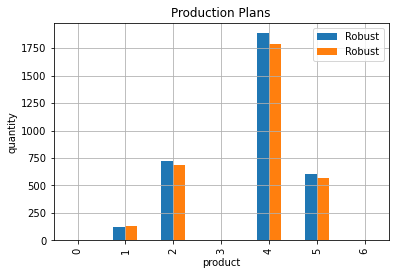

In [23]:
production_plans.plot(kind="bar", xlabel="product", ylabel="quantity", title="Production Plans", grid=True)

In [24]:
# compute profits for each plan by taking dot product
display(production_plans.T @ profit)

Robust    26950.67506
Robust    25709.93699
dtype: float64